In [16]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams['font.family'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [ ]:
data = pd.read_csv('toutiao_news.csv')
data['text'] =  data['标题'] + '。' + data['摘要']
data["text"] = data["text"]
# 标签编码
label_encoder = LabelEncoder()
data["label_id"] = label_encoder.fit_transform(data["类别"])
# 划分训练、验证、测试集
train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data["label_id"])
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42, stratify=train_val_data["label_id"])
# 构建 Dataset 和 DataLoader
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
train_dataset = TextDataset(train_data["text"].tolist(), train_data["label_id"].tolist())
val_dataset = TextDataset(val_data["text"].tolist(), val_data["label_id"].tolist())
test_dataset = TextDataset(test_data["text"].tolist(), test_data["label_id"].tolist())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
# 模型与优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=len(label_encoder.classes_))
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
# 训练与验证
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}/3")
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)
    train_acc = correct / total
    print(f"Train Loss: {epoch_loss / len(train_loader):.4f} | Train Acc: {train_acc:.4f}")
    # 验证
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == batch['labels']).sum().item()
            val_total += batch['labels'].size(0)
    val_acc = val_correct / val_total
    print(f"Val Loss: {val_loss / len(val_loader):.4f} | Val Acc: {val_acc:.4f}")
# 测试集评估
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())
# 输出结果
target_names = label_encoder.classes_
report = classification_report(all_labels, all_preds, target_names=target_names, digits=4)
print("\nBERT模型 分类报告:")
print(report)
hot = pd.read_csv('hot_news.csv')
hot['text'] = hot['标题'] + '0' + hot['摘要']
hot["text"] = hot["text"].apply(clean_text)

In [37]:
report = classification_report(all_labels, all_preds, target_names=target_names, digits=4)
print("\nBERT模型 分类报告:")
print(report)


BERT模型 分类报告:
              precision    recall  f1-score   support

          体育     0.9489    0.9489    0.9489       137
          军事     0.9375    0.9677    0.9524       124
          娱乐     0.9338    0.9407    0.9373       135
          旅游     0.9391    0.9000    0.9191       120
          科技     0.9123    0.8525    0.8814       122
          美食     0.9669    0.9865    0.9766       148
          财经     0.8812    0.9097    0.8952       155

    accuracy                         0.9309       941
   macro avg     0.9314    0.9294    0.9301       941
weighted avg     0.9309    0.9309    0.9307       941



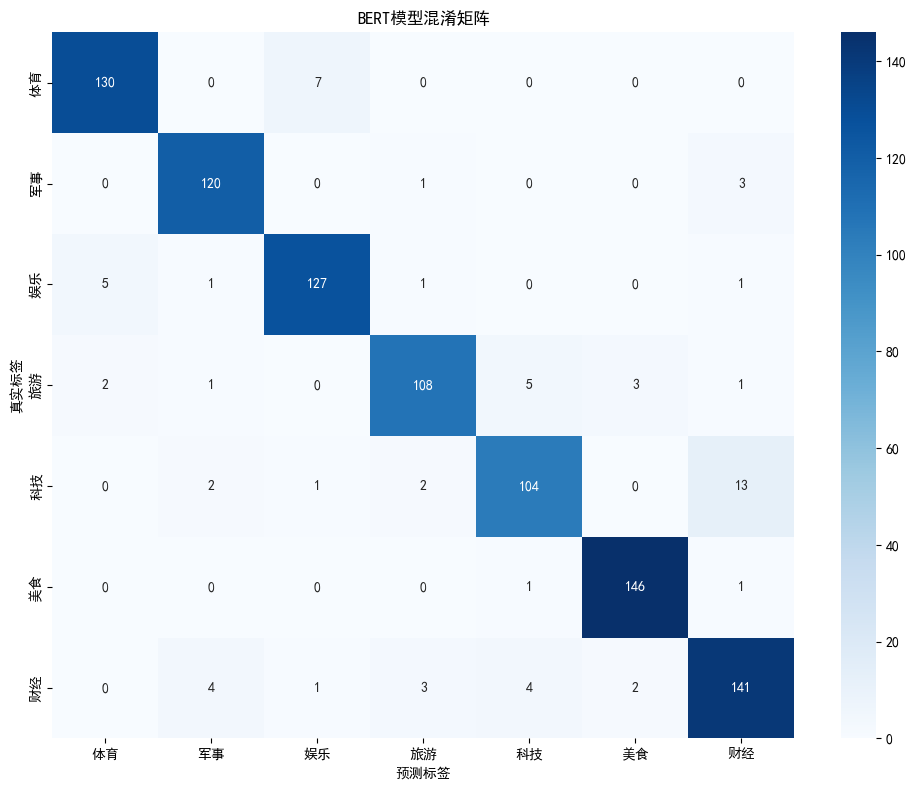

In [35]:
# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
target_names = label_encoder.classes_

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('BERT模型混淆矩阵')
plt.tight_layout()
plt.show()

In [ ]:
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')
model.save_pretrained("bert_clf")
tokenizer.save_pretrained("bert_clf")